In [1]:
%matplotlib inline 


import six
import Quandl
import calendar
import math
import numpy as np
import pandas as pd
import seaborn as sb
import pylab as pylab
from docx import Document
from datetime import datetime

from matplotlib import colors
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D

from scipy.interpolate import interp1d
import statsmodels.stats.stattools as stats_stattools
import statsmodels.tsa.stattools as tsa_stattools
import statsmodels.tsa.seasonal as tsa_seasonal
import statsmodels.api as sm 
import xgboost as xgb
from unbalanced_dataset import SMOTE

from sklearn import svm
from sklearn import metrics, cross_validation, linear_model, naive_bayes, neighbors, ensemble
from sklearn import feature_selection
from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import preprocessing

import sys
from os import listdir
from os.path import isfile, join
from helpers import features_analysis, procces_stocks, data_manipulation, download_quandl_data, ml_dataset, classifier_utils, report_generator, Iteration, Stacking, Boosting

fig_size = [10, 6]
plt.rcParams["figure.figsize"] = fig_size
sb.set_style('darkgrid')

log = open("log.txt", "w")

In [2]:
GOLD = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/GOLD.csv')
SILVER = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/SILVER.csv')
PLAT = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/PLAT.csv')
OIL_BRENT = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/OIL_BRENT.csv')
INDEX_DJIA = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_DJIA.csv')
INDEX_HSI = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_HSI.csv')
INDEX_IBEX = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_IBEX.csv')
INDEX_N225 = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_N225.csv')
INDEX_SP500 = data_manipulation.read_csv_data('/Users/Pablo/Desktop/TFM/Data/INDEX_SP500.csv')

values_names = ['GOLD', 'SILVER', 'PLAT', 'OIL_BRENT', 'DJIA', 'HSI', 'IBEX', 'N225', 'SP500']
values_dfs = [GOLD, SILVER, PLAT, OIL_BRENT, INDEX_DJIA, INDEX_HSI, INDEX_IBEX, INDEX_N225, INDEX_SP500]
values_cols = ['USD_AM', 'USD', 'USD_AM', 'USD', 'Open', 'Open', 'Open', 'Open', 'Open']
dict_dfs_cols = {}

for index in range(len(values_names)):
    name = values_names[index]
    df = values_dfs[index]    
    cols = df.columns.values
    new_cols = [x for x in cols if x not in ['Date']]
    #new_cols = [x for x in cols if x not in ['Date', 'USD_AM', 'USD_PM', 'USD', 'Open', 'High', 'Low', 'Close', 'Volume', 'Adjusted Close']]    
    
    dict_dfs_cols[name] = new_cols

dataset = ml_dataset.generate_df_dataset(values_names, values_dfs, dict_dfs_cols)

#First 30 row
dataset = dataset[31:]
dataset = dataset.reset_index(drop=True)
datasetY = dataset.copy(deep=True)
#dataset = dataset.fillna(method='ffill')

training_dates = Iteration.Iteration('2013-08-19', '2015-12-01')
testing_dates  = Iteration.Iteration('2016-01-04', '2016-04-20')
training_dates.calculate_indices(dataset)
testing_dates.calculate_indices(dataset)

trainDates = []
testDates = []
trainDates.append(training_dates.lowerIndex)
trainDates.append(training_dates.upperIndex)
testDates.append(testing_dates.lowerIndex)
testDates.append(testing_dates.upperIndex)
    
trainX, trainY, testX, testY, cols = ml_dataset.dataset_to_train_using_dates(dataset, trainDates, testDates, binary=False, shiftFeatures=False, shiftTarget=False)

In [3]:
training_dates = Iteration.Iteration('2014-08-19', '2015-12-01')
testing_dates  = Iteration.Iteration('2016-01-04', '2016-04-20')
training_dates.calculate_indices(dataset)
testing_dates.calculate_indices(dataset)

trainDates = []
testDates = []
trainDates.append(training_dates.lowerIndex)
trainDates.append(training_dates.upperIndex)
testDates.append(testing_dates.lowerIndex)
testDates.append(testing_dates.upperIndex)


colY = 'IBEX_RD_B1_Close'
experiments = {'Test 1': ["RD1_Close", "RD.?_Close", "RD_P1_Close", "RD_P.?_Close", "RD_B1_Close", "RD_B.?_Close"],
               'Test 2': ["RD1_(Open|Close)", "RD.?_(Open|Close)", "RD_P1_(Open|Close)", "RD_P.?_(Open|Close)", "RD_B1_(Open|Close)", "RD_B.?_(Open|Close)"],
               'Test 3': ["RD1_(Open|Close|High|Low|Volume)", "RD.?_(Open|Close|High|Low|Volume)", "RD_P1_(Open|Close|High|Low|Volume)", "RD_P.?_(Open|Close|High|Low|Volume)", "RD_B1_(Open|Close|High|Low|Volume)", "RD_B.?_(Open|Close|High|Low|Volume)"],
               'Test 4': ["^(GOLD|SILVER|PLAT|OIL_BRENT)_RD1", "^(GOLD|SILVER|PLAT|OIL_BRENT)_RD.?", "^(GOLD|SILVER|PLAT|OIL_BRENT)_RD_P1", "^(GOLD|SILVER|PLAT|OIL_BRENT)_RD_P.?", "^(GOLD|SILVER|PLAT|OIL_BRENT)_RD_B1", "^(GOLD|SILVER|PLAT|OIL_BRENT)_RD_B.?"],
               'Test 5': ["RD1_(USD|Close)", "RD.?_(USD|Close)", "RD_P1_(USD|Close)", "RD_P.?_(USD|Close)", "RD_B1_(USD|Close)", "RD_B.?_(USD|Close)"],
               'Test 6': ["RD1_(USD|Close|Open)", "RD.?_(USD|Close|Open)", "RD_P1_(USD|Close|Open)", "RD_P.?_(USD|Close|Open)", "RD_B1_(USD|Close|Open)", "RD_B.?_(USD|Close|Open)"],
               'Test 7': ["RD1", "RD_P.?_", "RD_P1", "RD_P.?_", "RD_B1", "RD_B.?_"],               
              }

regex_list2 = ["RD1_Close"]
algorithms_list = ['', 'RandomForest']
features_list = []

#df_y = dataset[colY]
df_y = dataset[colY].shift(-1)
last_row = df_y.shape[0]-1

 
df_y = df_y.drop(last_row, axis=0)

keys = experiments.keys()
keys.sort()

for key in keys:
    regex_list = experiments[key]
    print "####################"
    print "      %s      " % key 
    print "####################"    
    
    sub_index = 1
    for regex_element in regex_list:
        df_x = dataset.filter(regex=(regex_element))

        df_x = df_x.drop(last_row, axis=0)
        #df_y = df_y.drop(last_row, axis=0)
#        print df_x.columns
#        print df_x.shape
#        print df_y.name    
#        print df_y.shape 
        trainX, trainY, testX, testY = ml_dataset.train_arrays_experiments(df_x, df_y, trainDates, testDates)

        svc = ensemble.RandomForestClassifier(n_estimators=200)

        svc.fit(trainX, trainY)
        prediction = svc.predict(testX)
        fpr, tpr, _ = metrics.roc_curve(testY, prediction)
        print "> AUC: %.4f " % metrics.auc(fpr, tpr)
        auc = str(metrics.auc(fpr, tpr))
        print "> Score: %.4f " % svc.score(testX, testY)
        score = "%.2f" % (svc.score(testX, testY)*100)
        print metrics.classification_report(testY, prediction)
        precision =  metrics.classification_report(testY, prediction).split('\n')[5].split('      ')[1]
        recall = metrics.classification_report(testY, prediction).split('\n')[5].split('      ')[2]
        f1 = metrics.classification_report(testY, prediction).split('\n')[5].split('      ')[3] 
        cell = '<p>' + 'Score = ' + score + ' %<br/>F1 = ' + f1 + '</p>'        
        row = [key + '-'+ str(sub_index)]
        row.append(cell)
        features_list.append(row)
        sub_index = sub_index + 1
report_generator.pdf_tables(algorithms_list, features_list, "informe_esperanto.pdf")

SyntaxError: invalid syntax (<ipython-input-3-38ab93aa114b>, line 13)

In [3]:
N_TREES = 500
SEED = 42

selected_models = [
    "LRC:all_greedy",   
    "SGD:all_greedy"

#    "LDA:all_greedy" 
#    "QDA:all_greedy", 
#    
#    "SVM:all_greedy", 
#    
#    "NBG:all_greedy", 
#    "NBM:all_greedy", 
#    "NBB:all_greedy",
#
#    "KNN:all_greedy", 
#    
#    "ABC:all_greedy",
#    "BGC:all_greedy",
#    "GBC:all_greedy", 
#    "RFC:all_greedy",
#    "ETC:all_greedy"
]

algorithms_list = ['']

# Create the models on the fly
models = []
for item in selected_models:
    model_id, data_set = item.split(':')
    model = {'LRC':linear_model.LogisticRegression,
             'SGD':linear_model.SGDClassifier,
             
             'LDA':discriminant_analysis.LinearDiscriminantAnalysis,
             'QDA':discriminant_analysis.QuadraticDiscriminantAnalysis,
             
             'SVM':svm.SVC,
            
             'NBG':naive_bayes.GaussianNB,
             'NBM':naive_bayes.MultinomialNB,
             'NBB':naive_bayes.BernoulliNB,
             
             "KNN":neighbors.KNeighborsClassifier,

             'ABC': ensemble.AdaBoostClassifier,
             'BGC': ensemble.BaggingClassifier,             
             'GBC': ensemble.GradientBoostingClassifier,
             'RFC': ensemble.RandomForestClassifier,
             'ETC': ensemble.ExtraTreesClassifier        
            }[model_id]()
    models.append((model, data_set))
    algorithms_list.append(model_id)


grid_search = True
## Set params
for model, feature_set in models:
    model.set_params(**classifier_utils.find_params(model, feature_set, trainX, trainY, grid_search))

    
training_dates = Iteration.Iteration('1993-08-19', '2012-07-06')
testing_dates  = Iteration.Iteration('2012-07-09', '2016-04-20')
training_dates.calculate_indices(dataset)
testing_dates.calculate_indices(dataset)

trainDates = []
testDates = []
trainDates.append(training_dates.lowerIndex)
trainDates.append(training_dates.upperIndex)
testDates.append(testing_dates.lowerIndex)
testDates.append(testing_dates.upperIndex)
    
dates = {'Dates 1':
         [('1993-08-19', '2011-07-08', '2011-07-11', '2016-04-20'), ('1993-08-19', '2012-07-06','2012-07-09', '2016-04-20'),           ('1993-08-19', '2013-07-08', '2013-07-09', '2016-04-20')],
#         'Dates 2':
#         [('1993-08-19', '2000-08-18', '2000-08-21', '2001-08-20'), ('1995-08-18', '2002-08-19', '2002-08-20', '2003-08-20')]#,
#          ('1997-08-19', '2004-08-19', '2004-08-20', '2005-08-19'), ('1999-08-19', '2006-08-18', '2006-08-21', '2007-08-20'),
#          ('2001-08-17', '2008-08-19', '2008-08-20', '2009-08-20'), ('2003-08-19', '2010-08-19', '2010-08-19', '2011-08-19'),
#          ('2005-08-19', '2012-08-17', '2012-08-20', '2013-08-20'), ('2007-08-17', '2015-05-19', '2015-05-19', '2016-04-20')],
#         'Dates 3':         
#         [('1998-08-19', '2000-08-18', '2000-08-21', '2001-08-20'), ('2000-08-18', '2002-08-19', '2002-08-20', '2003-08-20'),
#          ('2002-08-19', '2004-08-19', '2004-08-20', '2005-08-19'), ('2004-08-19', '2006-08-18', '2006-08-21', '2007-08-20'),
#          ('2006-08-17', '2008-08-19', '2008-08-20', '2009-08-20'), ('2008-08-19', '2010-08-19', '2010-08-19', '2011-08-19'),
#          ('2010-08-19', '2012-08-17', '2012-08-20', '2013-08-20'), ('2012-08-17', '2015-05-19', '2015-05-19', '2016-04-20')],
#         'Dates 4':         
#         [('1993-08-19', '2000-08-18', '2000-08-21', '2000-09-21'), ('1995-08-18', '2002-08-19', '2002-08-20', '2002-09-20'),
#          ('1997-08-19', '2004-08-19', '2002-08-20', '2002-09-20'), ('1999-08-19', '2006-08-18', '2002-08-21', '2002-09-20'),
#          ('2001-08-17', '2008-08-19', '2008-08-20', '2008-09-22'), ('2003-08-19', '2010-08-19', '2010-08-19', '2010-09-20'),
#          ('2005-08-19', '2012-08-20', '2012-08-20', '2012-09-20'), ('2007-08-20', '2015-09-21', '2015-08-19', '2015-09-21')],
#         'Dates 5':                  
#         [('1998-08-19', '2000-08-18', '2000-08-21', '2000-09-20'), ('2000-08-18', '2002-08-19', '2002-08-20', '2002-09-20'),
#          ('2002-08-19', '2004-08-19', '2004-08-20', '2004-09-20'), ('2004-08-19', '2006-08-18', '2006-08-21', '2006-09-20'),
#          ('2006-08-18', '2008-08-19', '2008-08-20', '2008-09-22'), ('2008-08-19', '2010-08-19', '2010-08-19', '2010-09-20'),
#          ('2010-08-19', '2012-08-17', '2012-08-20', '2012-09-20'), ('2012-08-17', '2015-08-19', '2015-08-20', '2015-09-21')]
        }
    
colY = 'IBEX_RD_B1_Close'
experiments = {'Test 1': ["RD1_Close", "RD.?_Close"], #"RD_P1_Close", "RD_P.?_Close", "RD_B1_Close", "RD_B.?_Close"]
               'Test 2': ["RD1_(Open|Close)", "RD.?_(Open|Close)"]#, "RD_P1_(Open|Close)", "RD_P.?_(Open|Close)", "RD_B1_(Open|Close)", "RD_B.?_(Open|Close)"],
               #'Test 3': ["RD1_(Open|Close|High|Low|Volume)", "RD.?_(Open|Close|High|Low|Volume)", "RD_P1_(Open|Close|High|Low|Volume)", "RD_P.?_(Open|Close|High|Low|Volume)", "RD_B1_(Open|Close|High|Low|Volume)", "RD_B.?_(Open|Close|High|Low|Volume)"],
               #'Test 4': ["^(GOLD|SILVER|PLAT|OIL_BRENT)_RD1", "^(GOLD|SILVER|PLAT|OIL_BRENT)_RD.?", "^(GOLD|SILVER|PLAT|OIL_BRENT)_RD_P1", "^(GOLD|SILVER|PLAT|OIL_BRENT)_RD_P.?", "^(GOLD|SILVER|PLAT|OIL_BRENT)_RD_B1", "^(GOLD|SILVER|PLAT|OIL_BRENT)_RD_B.?"],
               #'Test 5': ["RD1_(USD|Close)", "RD.?_(USD|Close)", "RD_P1_(USD|Close)", "RD_P.?_(USD|Close)", "RD_B1_(USD|Close)", "RD_B.?_(USD|Close)"],
               #'Test 6': ["RD1_(USD|Close|Open)", "RD.?_(USD|Close|Open)", "RD_P1_(USD|Close|Open)", "RD_P.?_(USD|Close|Open)", "RD_B1_(USD|Close|Open)", "RD_B.?_(USD|Close|Open)"],
               #'Test 7': ["RD1", "RD_P.?_", "RD_P1", "RD_P.?_", "RD_B1", "RD_B.?_"]
              }

features_list = []
num_experiments = 1

#df_y = dataset[colY]
df_y = dataset[colY].shift(-1)
last_row = df_y.shape[0]-1
df_y = df_y.drop(last_row, axis=0)

keys_dates = dates.keys()
keys_dates.sort()
keys_exp = experiments.keys()
keys_exp.sort()

document = Document()
document.add_heading('Experimentos', 0)

print >> log, 'Dataset shape %s' % str(dataset.shape)
print >> log, 'Y shape %s' % str(df_y.shape)

for key_d in keys_dates:
    date_list = dates[key_d]
    document.add_heading(str(key_d), level=1)
    print "=================================================="
    print "                    %s                     " % key_d 
    print "=================================================="
    print >> log, "=================================================="
    print >> log, "                    %s                     " % str(key_d)
    print >> log, "=================================================="
    print >> log, "++++++++++++++++++++++++++++++++++++++++++++++++++"    
    
    ## Table headings
    table = document.add_table(rows=1, cols=len(algorithms_list))
    hdr_cells = table.rows[0].cells
    for i in range(len(algorithms_list)):
        hdr_cells[i].text = algorithms_list[i]
                    
    for key_exp in keys_exp:
        regex_list = experiments[key_exp]
        sub_index = 1
        iteration_scores = []
        for regex_element in regex_list:

            print "++++++++++++++++++++++++++++++++++++++++++++++++++"
            print "                   %s                  " % (key_exp + '-'+ str(sub_index)) 
            print "++++++++++++++++++++++++++++++++++++++++++++++++++"
            print >> log, "++++++++++++++++++++++++++++++++++++++++++++++++++"
            print >> log, "                  %s                  " % (key_exp + '.'+ str(sub_index))
            print >> log, "++++++++++++++++++++++++++++++++++++++++++++++++++"
        
            ##Trainig testing arrays
            df_x = dataset.filter(regex=(regex_element))
            df_x = df_x.drop(last_row, axis=0)

            print >> log, "df_x columns %s" % str(df_x.columns)
            print >> log, "df_x shape %s" % str(df_x.shape)
            print >> log, "df_y name %s" % str(df_y.name)  
            print >> log, "df_y shape %s" % str(df_y.shape)        
            
            iteration_dates = 1
            for date in date_list:
                
                print "++++++++++++++++++++++++++++++++++++++++++++++++++"
                print "                     %s                 " % str(iteration_dates) 
                print "++++++++++++++++++++++++++++++++++++++++++++++++++"
                print >> log, "++++++++++++++++++++++++++++++++++++++++++++++++++"
                print >> log, "                    %s                 " % str(iteration_dates)
                print >> log, "++++++++++++++++++++++++++++++++++++++++++++++++++"
        
                ## Training and testing indices
                training_dates = Iteration.Iteration(date[0], date[1])
                testing_dates  = Iteration.Iteration(date[2], date[3])
                training_dates.calculate_indices(dataset)
                testing_dates.calculate_indices(dataset)

                trainDates = []
                testDates = []
                trainDates.append(training_dates.lowerIndex)
                trainDates.append(training_dates.upperIndex)
                testDates.append(testing_dates.lowerIndex)
                testDates.append(testing_dates.upperIndex)

                total = (trainDates[1]-trainDates[0]) + (testDates[1]-testDates[0])
                tr = float(trainDates[1]-trainDates[0]) / total * 100.0
                te = float(testDates[1]-testDates[0]) / total * 100.0

                print >> log, "Training: from %s to %s" % (str(training_dates.startDate), str(training_dates.endDate))
                print >> log, "Testing: from %s to %s" % (str(testing_dates.startDate), str(testing_dates.endDate))
                print >> log, "%.3f %% training %.3f %% testing" % (tr,te)
                print >> log, "%d training %d testing" % (trainDates[1]-trainDates[0], testDates[1]-testDates[0])        
                trainX, trainY, testX, testY = ml_dataset.train_arrays_experiments(df_x, df_y, trainDates, testDates)
            
                ################
                ##  Stacking  ##
                ################
                clf = Stacking.Stacking(models, stack=True, fwls=False, model_selection=True, log=log)

                ###  Metrics
                print >> log, "computing cv score"
                mean_auc = 0.0
                mean_accuracy = 0.0
                iter_ = 1
                cv_preds, models_score, means_score, stacks_score = clf.fit_predict(trainY, trainX, testX, testY, show_steps=True)
                cv_preds_bin = np.round_(cv_preds, decimals=0)
                accuracy = metrics.accuracy_score(testY, cv_preds_bin)
                
                iteration_scores.append(models_score)                
                print >> log, "Accuracy: %.2f" % accuracy
                iteration_dates += 1
                num_experiments += 1
                
            sub_index += 1
            ##Table header
            row_cells = table.add_row().cells
            row_cells[0].text = key_exp + '.'+ str(sub_index)
            col = 1
            ##Table test X_X row
            for num_models in range(len(models_score)):
                cell = ""
                for iteration in iteration_scores:
#                    score_str = iteration[num_models]
                    cell = cell + ("%.2f\n" % (iteration[num_models]*100))
                row_cells[col].text = cell
                col += 1

            
    document.add_page_break()


document.save('experiments.docx')
log.close()
print "DONE. %s experiments" % str(num_experiments)

using params LR:all_greedy: {'penalty': u'l2', 'C': 1.5, 'random_state': 42}
using params SGDC:all_greedy: {'loss': 'log'}
                    Dates 1                     
++++++++++++++++++++++++++++++++++++++++++++++++++
                     Test 1                 
++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++
                     Test 1-1                 
++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++
                     Test 1-2                 
++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++
                     Test 2                 
++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++
                     Test 2-1                 
++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++++++++++++++++++++++++++++++++++
                     Test 2-2       

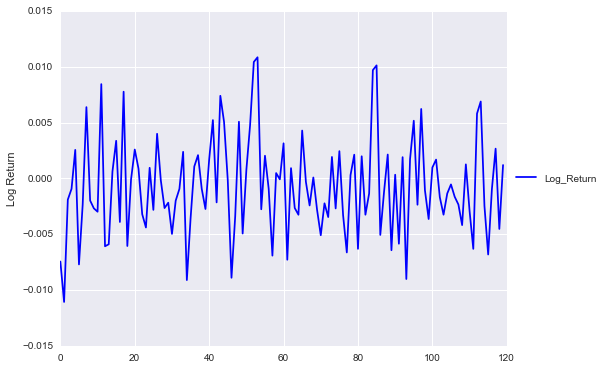

In [4]:
x = [datetime.strptime(d,'%Y-%m-%d').date() for d in INDEX_DJIA['Date'].tolist()]

x_array = np.asarray(x)
nlag = len(x)
range_show = nlag

plt.rcParams["figure.figsize"] = fig_size
pylab.figure(0)
ax = plt.subplot(111)
box = ax.get_position()


ax.plot(INDEX_DJIA['Log_Return'][:120], 'b')
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('Log Return')
plt.savefig('/Users/Pablo/Desktop/figure2.png')


In [14]:
N_TREES = 500
SEED = 42


selected_models = [
    "LRC:all_greedy",   
    "SGD:all_greedy",
    
    "LDA:all_greedy", 
    "QDA:all_greedy", 
    
    "SVM:all_greedy", 
    
    "NBG:all_greedy", 
    "NBM:all_greedy", 
    "NBB:all_greedy", 

    "KNN:all_greedy", 
    
    "ABC:all_greedy",
    "BGC:all_greedy",
    "GBC:all_greedy", 
    "RFC:all_greedy",
    "ETC:all_greedy"
]

# Create the models on the fly
models = []
for item in selected_models:
    model_id, data_set = item.split(':')
    model = {'LRC':linear_model.LogisticRegression,
             'SGD':linear_model.SGDClassifier,
             
             'LDA':discriminant_analysis.LinearDiscriminantAnalysis,
             'QDA':discriminant_analysis.QuadraticDiscriminantAnalysis,
             
             'SVM':svm.SVC,
            
             'NBG':naive_bayes.GaussianNB,
             'NBM':naive_bayes.MultinomialNB,
             'NBB':naive_bayes.BernoulliNB,
             
             "KNN":neighbors.KNeighborsClassifier,

             'ABC': ensemble.AdaBoostClassifier,
             'BGC': ensemble.BaggingClassifier,             
             'GBC': ensemble.GradientBoostingClassifier,
             'RFC': ensemble.RandomForestClassifier,
             'ETC': ensemble.ExtraTreesClassifier        
            }[model_id]()
    models.append((model, data_set))

grid_search = True
## Set params
for model, feature_set in models:
    model.set_params(**classifier_utils.find_params(model, feature_set, trainX, trainY, grid_search))

LRC
all_greedy
SGD
all_greedy
LDA
all_greedy
QDA
all_greedy
SVM
all_greedy
NBG
all_greedy
NBM
all_greedy
NBB
all_greedy
KNN
all_greedy
ABC
all_greedy
BGC
all_greedy
GBC
all_greedy
RFC
all_greedy
ETC
all_greedy
using params LR:all_greedy: {'penalty': u'l2', 'C': 1.5, 'random_state': 42}
using params SGDC:all_greedy: {'loss': 'log'}
using params LDA:all_greedy: {}
using params QDA:all_greedy: {}
found params (SVC:all_greedy > 0.5250): {'kernel': 'linear', 'C': 5, 'decision_function_shape': 'ovo', 'degree': 3, 'shrinking': False}
using params GNB:all_greedy: {}
found params (MNB:all_greedy > 0.5297): {'alpha': 1.0, 'fit_prior': True}
found params (BNB:all_greedy > 0.5574): {'alpha': 0.0, 'fit_prior': True}
found params (KNC:all_greedy > 0.4847): {'n_neighbors': 10, 'weights': 'distance', 'algorithm': 'ball_tree', 'p': 3}
found params (ABC:all_greedy > 0.5789): {'n_estimators': 5, 'learning_rate': 0.08}
found params (BC:all_greedy > 0.4733): {'n_estimators': 10}
found params (GBC:all_greed

In [15]:
################
##  Stacking  ##
################
clf = Stacking.Stacking(models, stack=True, fwls=False,
                           model_selection=True)

###  Metrics
print("computing cv score")
mean_auc = 0.0
iter_ = 1
for i in range(iter_):        
    cv_preds = clf.fit_predict(trainY, trainX, testX, testY, show_steps=True)

    fpr, tpr, _ = metrics.roc_curve(testY, cv_preds)
    roc_auc = metrics.auc(fpr, tpr)
    print "AUC (fold %d/%d): %.5f" % (i + 1, iter_, roc_auc)
    mean_auc += roc_auc

    print "Mean AUC: %.5f" % (mean_auc/iter_)
    
#dat = '2016-04-20'
#dataset.Date[dataset.Date == dat].index[0]

computing cv score
> AUC: 0.6858 (0.6858, 0.3142, 0.0000) [LR:all_greedy]
> AUC: 0.5527 (0.6456, 0.3673, 0.0000) [SGDC:all_greedy]
> AUC: 0.6793 (0.6449, 0.3580, 0.0000) [LDA:all_greedy]
> AUC: 0.5258 (0.6155, 0.4419, 0.0000) [QDA:all_greedy]
> AUC: 0.3135 (0.6162, 0.4419, 0.0000) [SVC:all_greedy]
> AUC: 0.6126 (0.6076, 0.5129, 0.0000) [GNB:all_greedy]
> AUC: 0.6363 (0.6176, 0.4254, 0.0000) [MNB:all_greedy]
> AUC: 0.6176 (0.6083, 0.5208, 0.0000) [BNB:all_greedy]
> AUC: 0.5395 (0.5990, 0.4950, 0.0000) [KNC:all_greedy]
> AUC: 0.6894 (0.6047, 0.5925, 0.0000) [ABC:all_greedy]
> AUC: 0.5423 (0.6076, 0.5825, 0.0000) [BC:all_greedy]
> AUC: 0.5674 (0.6255, 0.5581, 0.0000) [GBC:all_greedy]
> AUC: 0.6248 (0.6298, 0.5273, 0.0000) [RFC:all_greedy]
> AUC: 0.6083 (0.6298, 0.5280, 0.0000) [ETC:all_greedy]
- best subset auc (7 models): 0.6772 > [0, 2, 4, 6, 9, 12, 13]
- best subset auc (8 models): 0.6621 > [0, 2, 4, 5, 6, 9, 12, 13]
- best subset auc (9 models): 0.6528 > [0, 2, 5, 6, 7, 9, 11, 12, 13]

In [213]:

trainingPeriodList = [365, 365*2,365*3]
testingPeriodList = [1,5,10,30,40,40]
stepList = [100, 200, 300, 400]

for trainingPeriod in trainingPeriodList:
    for testingPeriod in testingPeriodList:
        for step in stepList:

            print "#######################################"
            print "\t Training period %s" % (trainingPeriod)
            print "\t Testing period %s" % (testingPeriod)
            print "\t Step %s" % (step)
            print "#######################################\n"

            init = trainingPeriod + testingPeriod
            match = 0
            missmatch = 0
            
            for index in range(init,dataset.shape[0], step):


                trainDates = []
                testDates = []
                trainDates.append(index - trainingPeriod - testingPeriod)
                trainDates.append(index - testingPeriod)
                testDates.append(index -  testingPeriod + 1)
                testDates.append(index)

                #print "%s %s %s %s" % (trainDates[0], trainDates[1], testDates[0], testDates[1])

                #print "==========================="
                #print "Iteration %s" % (i)
                #print "Training: from %s to %s" % (dataset.Date[trainDates[0]], dataset.Date[trainDates[1]])
                #print "Testing: from %s to %s" % (dataset.Date[testDates[0]], dataset.Date[testDates[1]])

                trainX, trainY, testX, testY, cols = ml_dataset.dataset_to_train_using_dates(dataset, trainDates, testDates, binary=False, shiftFeatures=False, shiftTarget=False)
                #print "%s %s %s %s" % (trainX.shape,trainY.shape,testX.shape,testY.shape)

                ## SVM
                scv = svm.SVC(kernel='rbf')
                scv.fit(trainX, trainY)
                predictions = scv.predict(testX)
                
 
                
                if testY[testingPeriod-1] == predictions[testingPeriod-1]: 
                    match = match + 1
                else: 
                    missmatch = missmatch + 1  

                #print scv.score(testX, testY)
                #print metrics.classification_report(testY, scv.predict(testX))
                #if testingPeriod > 1:     print metrics.roc_auc_score(testY, scv.predict(testX))
            print "%.2f hit " % (float(match)/(match+missmatch))



#######################################
	 Training period 1095
	 Testing period 1
	 Step 10
#######################################

0.60 hit 


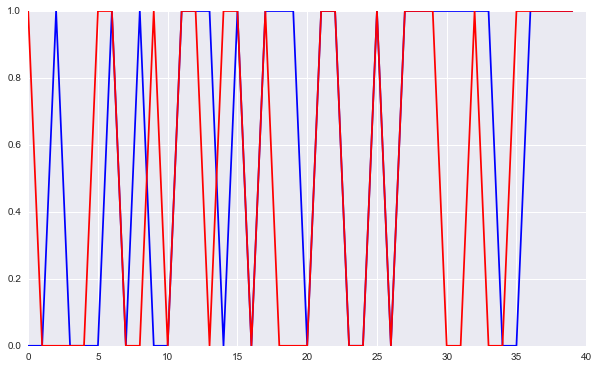

In [85]:
cv_preds = prediction
cv_preds[cv_preds >= 0.5] = 1
ones = np.where(cv_preds == 1)
cv_preds[cv_preds < 0.5] = 0
zeros = np.where(cv_preds == 0)

plt.figure()
plt.plot(cv_preds[0:40], c='blue')
plt.plot(testY[0:40], c='red')
plt.show()

In [49]:
from sklearn import neighbors
#svc = neighbors.KNeighborsClassifier()
#svc = svm.SVC(decision_function_shape='ovr')
svc = ensemble.RandomForestClassifier(n_estimators=200)

svc.fit(trainX, trainY)
prediction = svc.predict(testX)
fpr, tpr, _ = metrics.roc_curve(testY, prediction)
print "> AUC: %.4f " % metrics.auc(fpr, tpr)
print "> Score: %.4f " % svc.score(testX, testY)
print metrics.classification_report(testY, prediction)

> AUC: 0.4286 
> Score: 0.7500 
             precision    recall  f1-score   support

          0       0.00      0.00      0.00         1
          1       0.86      0.86      0.86         7

avg / total       0.75      0.75      0.75         8



In [20]:
# Support Vector Machine
from sklearn import datasets

# load the iris datasets
dataset = datasets.load_iris()
# fit a SVM model to the data
model = svm.SVC()
model.fit(dataset.data, dataset.target)
print(model)
# make predictions
expected = dataset.target
predicted = model.predict(dataset.data)
# summarize the fit of the model
print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))
print dataset.data.dtype
print dataset.target.dtype

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        50
          1       1.00      0.96      0.98        50
          2       0.96      1.00      0.98        50

avg / total       0.99      0.99      0.99       150

[[50  0  0]
 [ 0 48  2]
 [ 0  0 50]]
float64
int64


In [31]:
#data_manipulation.write_csv_data(GOLD, '/Users/Pablo/Desktop/TFM/Data/GOLD.csv')
#data_manipulation.write_csv_data(SILVER, '/Users/Pablo/Desktop/TFM/Data/SILVER.csv')
#data_manipulation.write_csv_data(PLAT, '/Users/Pablo/Desktop/TFM/Data/PLAT.csv')
#data_manipulation.write_csv_data(OIL_BRENT, '/Users/Pablo/Desktop/TFM/Data/OIL_BRENT.csv')
#data_manipulation.write_csv_data(INDEX_DJIA, '/Users/Pablo/Desktop/TFM/Data/INDEX_DJIA.csv')
#data_manipulation.write_csv_data(INDEX_HSI, '/Users/Pablo/Desktop/TFM/Data/INDEX_HSI.csv')
#data_manipulation.write_csv_data(INDEX_IBEX, '/Users/Pablo/Desktop/TFM/Data/INDEX_IBEX.csv')
#data_manipulation.write_csv_data(INDEX_N225, '/Users/Pablo/Desktop/TFM/Data/INDEX_N225.csv')
#data_manipulation.write_csv_data(INDEX_SP500, '/Users/Pablo/Desktop/TFM/Data/INDEX_SP500.csv')

(<docx.table._Cell object at 0x10ca60050>, <docx.table._Cell object at 0x10e703650>, <docx.table._Cell object at 0x10e703810>)
